<a href="https://colab.research.google.com/github/alexiacanosa/pruebas_monai/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](https://github.com/Project-MONAI/tutorials/blob/main/figures/spleen0.png?raw=1)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [8]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.9 MB/s eta 0:00:00


## Setup imports

In [9]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.6.dev2544
Numpy version: 2.0.2
Pytorch version: 2.8.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: f910be902091ce9efdc2928e1eb473fd607bfeb9
MONAI __file__: /usr/local/lib/python3.12/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.23.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.57.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [10]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp38z1961a


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [11]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:33, 47.4MB/s]                            

2025-11-05 19:00:55,488 - INFO - Downloaded: /tmp/tmp38z1961a/Task09_Spleen.tar


2025-11-05 19:00:58,325 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-11-05 19:00:58,326 - INFO - Writing into directory: /tmp/tmp38z1961a.


## Set MSD Spleen dataset path

In [12]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [13]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [14]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


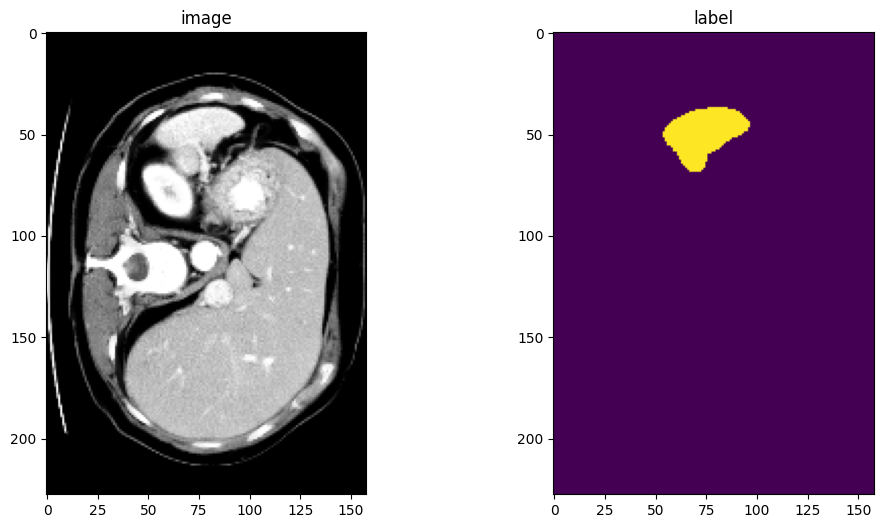

In [15]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [16]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 32/32 [01:36<00:00,  3.03s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading dataset: 100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


In [17]:
import torch
print("GPU disponible:", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ninguna")

GPU disponible: True
Nombre de GPU: Tesla T4


## Create Model, Loss, Optimizer

In [18]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [19]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/70
1/16, train_loss: 0.6680
2/16, train_loss: 0.6766
3/16, train_loss: 0.6748
4/16, train_loss: 0.6673
5/16, train_loss: 0.6558
6/16, train_loss: 0.6692
7/16, train_loss: 0.6452
8/16, train_loss: 0.6658
9/16, train_loss: 0.6554
10/16, train_loss: 0.6404
11/16, train_loss: 0.6571
12/16, train_loss: 0.6305
13/16, train_loss: 0.6524
14/16, train_loss: 0.6561
15/16, train_loss: 0.6549
16/16, train_loss: 0.6324
epoch 1 average loss: 0.6564
----------
epoch 2/70
1/16, train_loss: 0.6039
2/16, train_loss: 0.6501
3/16, train_loss: 0.6466
4/16, train_loss: 0.6381
5/16, train_loss: 0.6552
6/16, train_loss: 0.6130
7/16, train_loss: 0.6224
8/16, train_loss: 0.6369
9/16, train_loss: 0.6207
10/16, train_loss: 0.6020
11/16, train_loss: 0.6414
12/16, train_loss: 0.6310
13/16, train_loss: 0.6520
14/16, train_loss: 0.6253
15/16, train_loss: 0.6335
16/16, train_loss: 0.6090
epoch 2 average loss: 0.6301


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out

saved new best metric model
current epoch: 2 current mean dice: 0.0341
best mean dice: 0.0341 at epoch: 2
----------
epoch 3/70
1/16, train_loss: 0.5867
2/16, train_loss: 0.6045
3/16, train_loss: 0.6331
4/16, train_loss: 0.6398
5/16, train_loss: 0.6151
6/16, train_loss: 0.6132
7/16, train_loss: 0.6115
8/16, train_loss: 0.6261
9/16, train_loss: 0.6160
10/16, train_loss: 0.6170
11/16, train_loss: 0.6126
12/16, train_loss: 0.6265
13/16, train_loss: 0.6220
14/16, train_loss: 0.5990
15/16, train_loss: 0.6072
16/16, train_loss: 0.6222
epoch 3 average loss: 0.6158
----------
epoch 4/70
1/16, train_loss: 0.6138
2/16, train_loss: 0.6070
3/16, train_loss: 0.5618
4/16, train_loss: 0.5859
5/16, train_loss: 0.5759
6/16, train_loss: 0.6148
7/16, train_loss: 0.5590
8/16, train_loss: 0.6308
9/16, train_loss: 0.6232
10/16, train_loss: 0.6147
11/16, train_loss: 0.5949
12/16, train_loss: 0.5906
13/16, train_loss: 0.6221
14/16, train_loss: 0.6053
15/16, train_loss: 0.5907
16/16, train_loss: 0.6195
epoch 4

In [20]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8491 at epoch: 70


## Plot the loss and metric

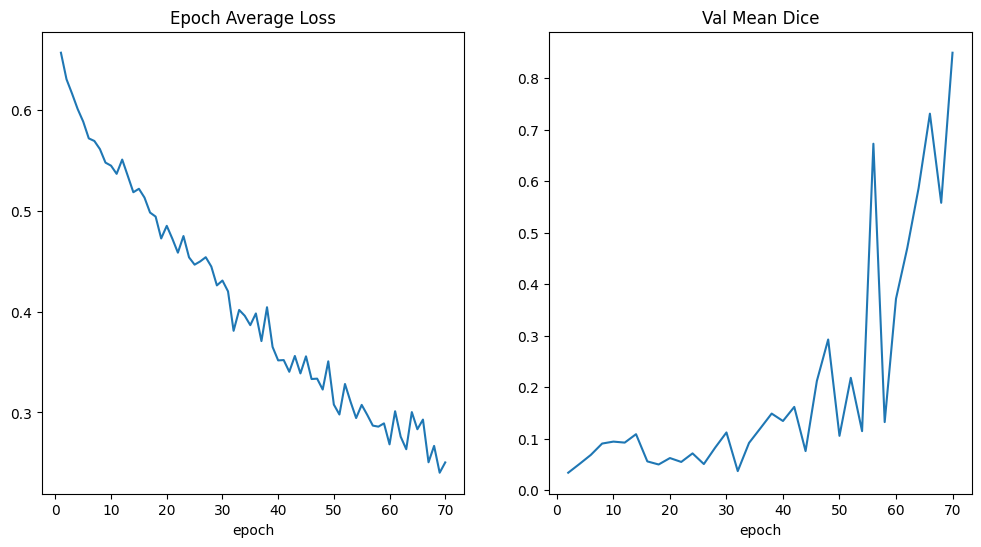

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

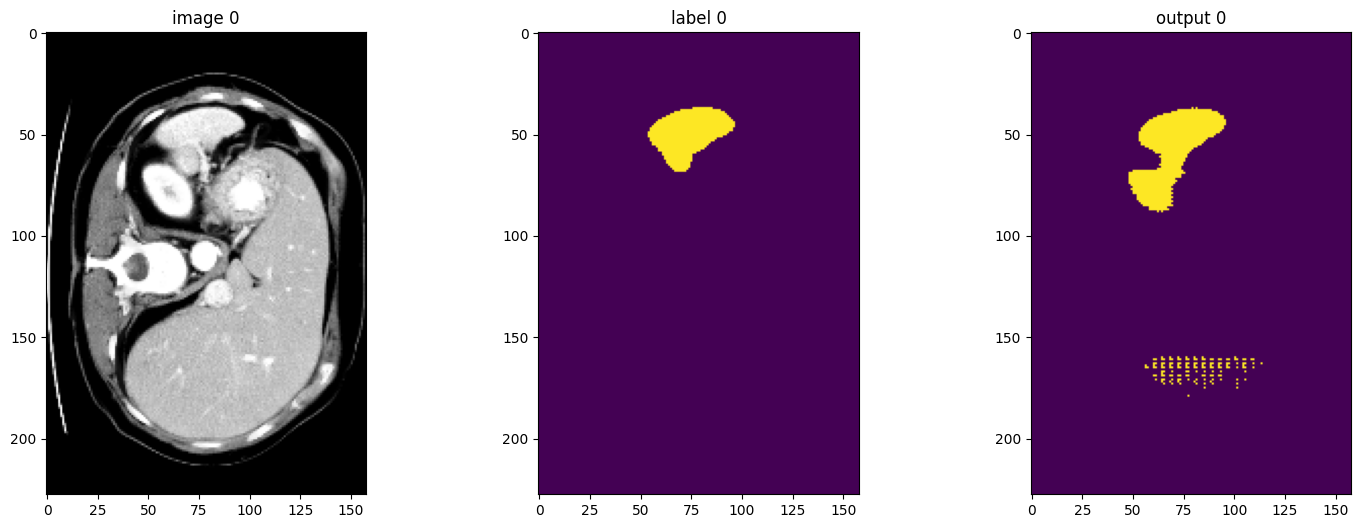

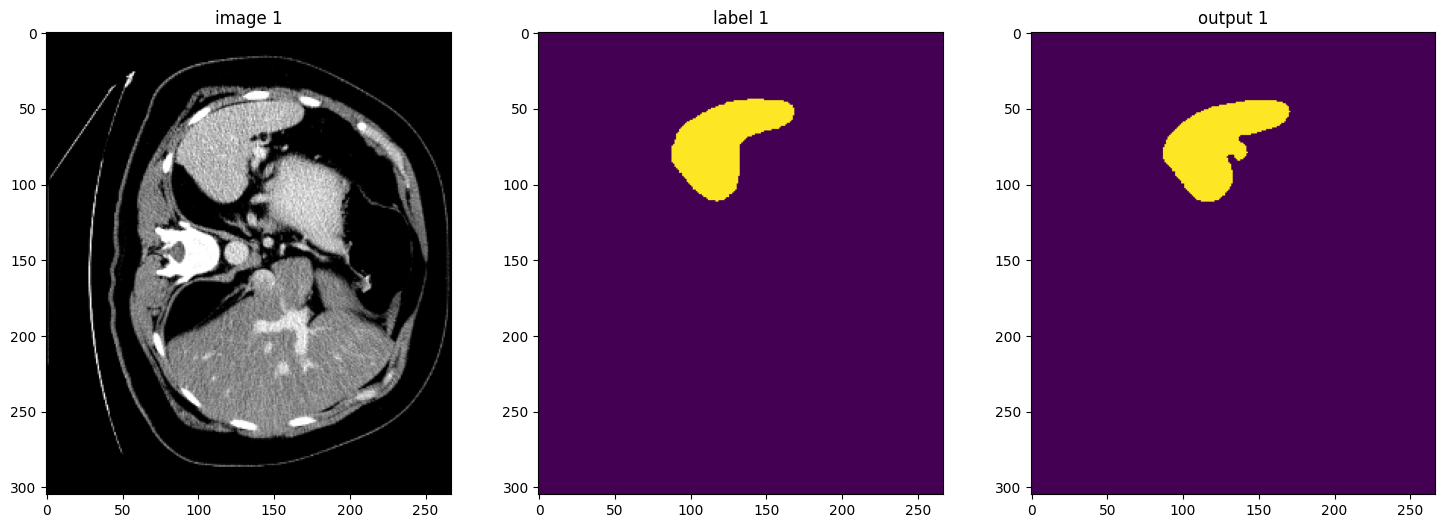

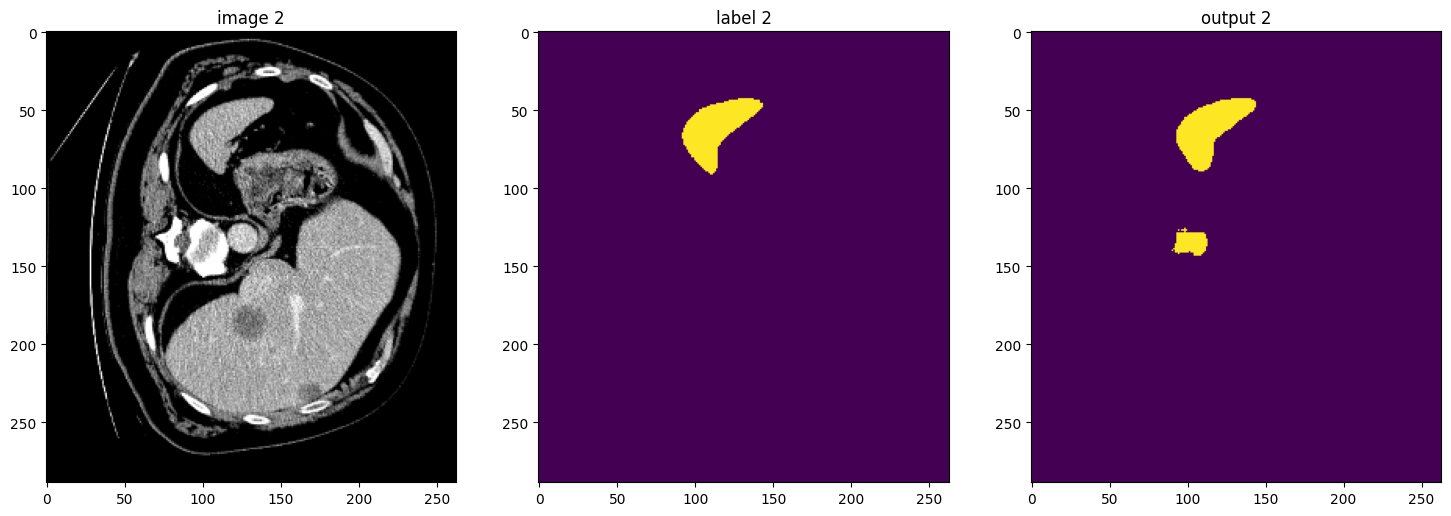

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [23]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [24]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.8717213273048401


## Inference on Test Set

In [25]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [26]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [27]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

2025-11-05 19:29:45,818 INFO image_writer.py:197 - writing: out/spleen_1/spleen_1_seg.nii.gz
2025-11-05 19:29:53,580 INFO image_writer.py:197 - writing: out/spleen_11/spleen_11_seg.nii.gz
2025-11-05 19:30:06,290 INFO image_writer.py:197 - writing: out/spleen_15/spleen_15_seg.nii.gz
2025-11-05 19:30:09,746 INFO image_writer.py:197 - writing: out/spleen_23/spleen_23_seg.nii.gz
2025-11-05 19:30:15,718 INFO image_writer.py:197 - writing: out/spleen_30/spleen_30_seg.nii.gz
2025-11-05 19:30:20,677 INFO image_writer.py:197 - writing: out/spleen_34/spleen_34_seg.nii.gz
2025-11-05 19:30:22,959 INFO image_writer.py:197 - writing: out/spleen_35/spleen_35_seg.nii.gz
2025-11-05 19:30:27,653 INFO image_writer.py:197 - writing: out/spleen_36/spleen_36_seg.nii.gz
2025-11-05 19:30:35,329 INFO image_writer.py:197 - writing: out/spleen_37/spleen_37_seg.nii.gz
2025-11-05 19:30:39,468 INFO image_writer.py:197 - writing: out/spleen_39/spleen_39_seg.nii.gz
2025-11-05 19:30:43,378 INFO image_writer.py:197 - w

## Cleanup data directory

Remove directory if a temporary was used.

# inferencia para mis imágenes:

In [64]:
# ⚠️ Esto borra TODO en /content, incluyendo outputs o modelos guardados.
!rm -rf /content/*
!mkdir -p /content/outputs
print("Directorio /content limpiado ✅")

Directorio /content limpiado ✅


In [65]:
from google.colab import files
uploaded = files.upload()  # selecciona tus .nii.gz desde tu ordenador

Saving CHUM-001__CT.nii.gz to CHUM-001__CT.nii.gz


In [48]:
# Mostrar los archivos subidos
import os
print("Archivos subidos:")
for fn in uploaded.keys():
    print(f"- {fn}")

# Guardar rutas absolutas
data_dir = os.getcwd()  # el directorio actual en Colab
print("Directorio actual:", data_dir)

Archivos subidos:
- CHUM-001__CT.nii.gz
- CHUM-001__PT.nii.gz
- CHUM-001.nii.gz
Directorio actual: /content


In [49]:
# ============================================================
# 🧰 Preparar tus datos subidos
# ============================================================
# 🔹 Crea lista con las rutas de los archivos subidos
# (Se añaden automáticamente los nombres subidos desde files.upload)
data_files = [{"image": os.path.join(data_dir, fname)} for fname in uploaded.keys()]
print("Archivos para segmentar:")
for f in data_files:
    print(f["image"])

Archivos para segmentar:
/content/CHUM-001__CT.nii.gz
/content/CHUM-001__PT.nii.gz
/content/CHUM-001.nii.gz


In [50]:
val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear")),
    ScaleIntensityRanged(
        keys=["image"], a_min=-100, a_max=400, b_min=0.0, b_max=1.0, clip=True
    ),
])

In [51]:
from monai.data import Dataset, DataLoader

val_ds = Dataset(data=data_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [54]:
batch_data = next(iter(val_loader))
print("Claves del batch:", batch_data.keys())

Claves del batch: dict_keys(['image'])


In [59]:
import os
import nibabel as nib
import numpy as np
import torch

os.makedirs("/content/outputs", exist_ok=True)
print("🔍 Iniciando inferencia sobre las imágenes cargadas...")

for i, batch_data in enumerate(val_loader):
    inputs = batch_data["image"].to(device)

    with torch.no_grad():
        outputs = sliding_window_inference(inputs, (96, 96, 96), 4, model)
        outputs = torch.argmax(outputs, dim=1, keepdim=True).cpu().numpy()

    for j, seg in enumerate(outputs):
        seg = seg[0].astype(np.uint8)  # ✅ convertir a tipo compatible NIfTI
        affine = np.eye(4)  # matriz identidad
        filename = f"seg_{i}_{j}.nii.gz"
        nib.save(nib.Nifti1Image(seg, affine), f"/content/outputs/{filename}")
        print(f"✅ Guardado: /content/outputs/{filename}")

print("🏁 Segmentaciones guardadas correctamente en /content/outputs/")

🔍 Iniciando inferencia sobre las imágenes cargadas...
✅ Guardado: /content/outputs/seg_0_0.nii.gz
✅ Guardado: /content/outputs/seg_1_0.nii.gz
✅ Guardado: /content/outputs/seg_2_0.nii.gz
🏁 Segmentaciones guardadas correctamente en /content/outputs/


Archivos segmentados encontrados:
- /content/outputs/seg_0_0.nii.gz
- /content/outputs/seg_1_0.nii.gz
- /content/outputs/seg_2_0.nii.gz

Archivos originales disponibles:
- CHUM-001.nii.gz
- CHUM-001__PT.nii.gz
- CHUM-001__CT.nii.gz

Usando segmentación: /content/outputs/seg_0_0.nii.gz
Usando imagen original: /content/CHUM-001.nii.gz


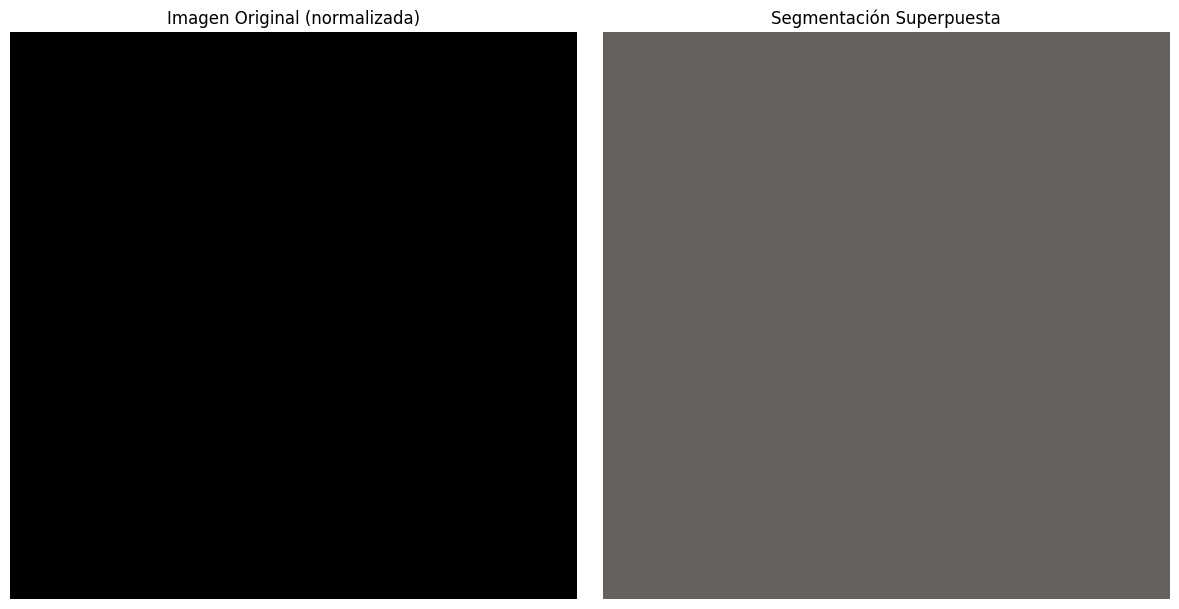

In [63]:
# ============================================================
# 👁️ Visualización 2D de los resultados (versión corregida)
# ============================================================
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

# Directorio donde se guardaron las segmentaciones
output_dir = "/content/outputs"

# Buscar archivos segmentados
seg_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".nii.gz")])
print("Archivos segmentados encontrados:")
for f in seg_files:
    print("-", f)

# Elegir un archivo segmentado para visualizar (puedes cambiar el índice)
seg_path = seg_files[0]

# Buscar una imagen original que coincida con el caso (CT, PT o combinada)
# Puedes ajustar el nombre si quieres forzar uno en específico.
possible_imgs = [f for f in os.listdir("/content/") if f.endswith(".nii.gz")]

print("\nArchivos originales disponibles:")
for f in possible_imgs:
    print("-", f)

# Si tienes varias, elige la que quieras asociar (por ahora tomamos la primera)
img_path = os.path.join("/content/", possible_imgs[0])

print(f"\nUsando segmentación: {seg_path}")
print(f"Usando imagen original: {img_path}")

# Cargar imagen original y segmentación
seg_data = nib.load(seg_path).get_fdata()
img_data = nib.load(img_path).get_fdata()

# Normalizar la imagen original a [0, 1]
img_data = np.clip(img_data, np.percentile(img_data, 1), np.percentile(img_data, 99))
img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min() + 1e-8)

# Asegurar que la máscara sea binaria (0 o 1)
seg_data = (seg_data > 0.5).astype(np.uint8)

# Elegir corte central (eje axial)
z_slice = seg_data.shape[2] // 2

# Visualizar
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_data[:, :, z_slice], cmap="gray")
plt.title("Imagen Original (normalizada)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_data[:, :, z_slice], cmap="gray")
plt.imshow(seg_data[:, :, z_slice], cmap="Reds", alpha=0.4)  # máscara roja semitransparente
plt.title("Segmentación Superpuesta")
plt.axis("off")

plt.tight_layout()
plt.show()

In [62]:
# ============================================================
# 🧭 Visualización 3D interactiva con sliders
# ============================================================
import matplotlib.pyplot as plt
from ipywidgets import interact

def explore_3d(image, seg, axis=2):
    slices = image.shape[axis]
    def view(slice_idx=0):
        plt.figure(figsize=(6,6))
        if axis == 0:
            img_slice = image[slice_idx, :, :]
            seg_slice = seg[slice_idx, :, :]
        elif axis == 1:
            img_slice = image[:, slice_idx, :]
            seg_slice = seg[:, slice_idx, :]
        else:
            img_slice = image[:, :, slice_idx]
            seg_slice = seg[:, :, slice_idx]
        plt.imshow(img_slice, cmap="gray")
        plt.imshow(seg_slice, cmap="jet", alpha=0.5)
        plt.axis("off")
        plt.title(f"Corte {slice_idx}")
        plt.show()
    interact(view, slice_idx=(0, slices - 1))

# Ejecutar visualización
explore_3d(img_data, seg_data)

interactive(children=(IntSlider(value=0, description='slice_idx', max=90), Output()), _dom_classes=('widget-in…

solo para CT

In [66]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged, EnsureTyped
from monai.data import Dataset, DataLoader

# Crear la lista con una sola imagen
data = [{"image": "/content/CHUM-001__CT.nii.gz"}]

# Definir transformaciones (mismo pipeline del cuaderno original)
val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear")),
    ScaleIntensityRanged(keys=["image"], a_min=-1000, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"])
])

# Crear dataset y loader
val_ds = Dataset(data=data, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [67]:
import os
import nibabel as nib
import numpy as np
import torch

os.makedirs("/content/outputs", exist_ok=True)
model.eval()

for i, batch_data in enumerate(val_loader):
    inputs = batch_data["image"].to(device)

    with torch.no_grad():
        outputs = sliding_window_inference(inputs, (96, 96, 96), 4, model)
        outputs = torch.argmax(outputs, dim=1, keepdim=True).cpu().numpy()

    for j, seg in enumerate(outputs):
        seg = seg[0].astype(np.uint8)
        affine = np.eye(4)
        filename = f"seg_CT_{i}_{j}.nii.gz"
        nib.save(nib.Nifti1Image(seg, affine), f"/content/outputs/{filename}")
        print(f"✅ Guardado: /content/outputs/{filename}")

✅ Guardado: /content/outputs/seg_CT_0_0.nii.gz


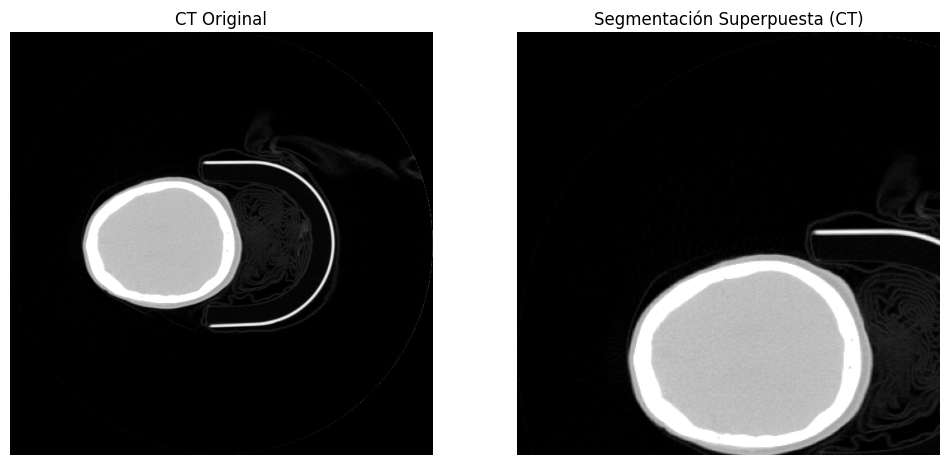

In [68]:
import matplotlib.pyplot as plt

img_path = "/content/CHUM-001__CT.nii.gz"
seg_path = "/content/outputs/seg_CT_0_0.nii.gz"

img_data = nib.load(img_path).get_fdata()
seg_data = nib.load(seg_path).get_fdata()

# Normalizar intensidades CT
img_data = np.clip(img_data, -1000, 400)
img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())

# Asegurar que la máscara sea binaria
seg_data = (seg_data > 0.5).astype(np.uint8)

z_slice = seg_data.shape[2] // 2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_data[:, :, z_slice], cmap="gray")
plt.title("CT Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_data[:, :, z_slice], cmap="gray")
plt.imshow(np.ma.masked_where(seg_data[:, :, z_slice] == 0, seg_data[:, :, z_slice]),
           cmap="autumn", alpha=0.6)
plt.title("Segmentación Superpuesta (CT)")
plt.axis("off")
plt.show()

In [69]:
import numpy as np
import nibabel as nib

seg_path = "/content/outputs/seg_CT_0_0.nii.gz"
seg_data = nib.load(seg_path).get_fdata()

print("Valores únicos en la máscara:", np.unique(seg_data))
print("Suma total de voxels segmentados:", np.sum(seg_data))

Valores únicos en la máscara: [0. 1.]
Suma total de voxels segmentados: 73096.0


IndexError: index 111 is out of bounds for axis 2 with size 91

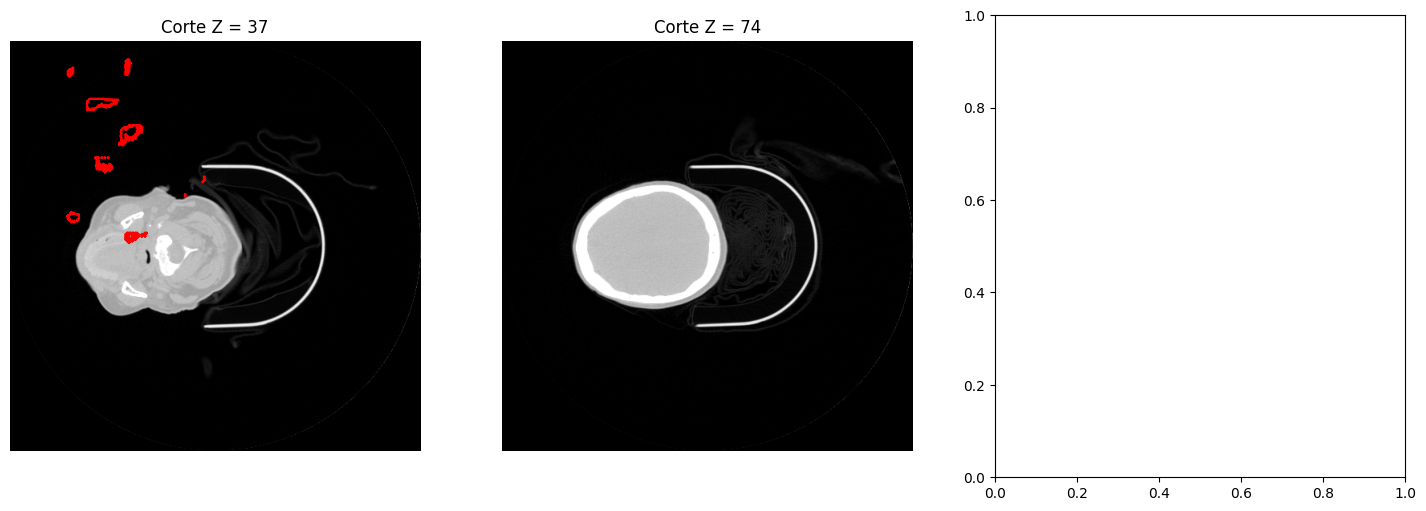

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Cargar la imagen CT y la segmentación
img_path = "/content/CHUM-001__CT.nii.gz"
seg_path = "/content/outputs/seg_CT_0_0.nii.gz"

img_data = nib.load(img_path).get_fdata()
seg_data = nib.load(seg_path).get_fdata()

# Normalizar intensidades de la CT
img_data = np.clip(img_data, -1000, 400)
img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())

# Cortes centrales
z_slices = [
    seg_data.shape[2] // 4,
    seg_data.shape[2] // 2,
    3 * seg_data.shape[2] // 4
]

plt.figure(figsize=(18, 6))
for i, z in enumerate(z_slices):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_data[:, :, z], cmap="gray")
    # máscara con borde rojo visible
    plt.contour(seg_data[:, :, z], colors='red', linewidths=1)
    plt.title(f"Corte Z = {z}")
    plt.axis("off")

plt.suptitle("CT + Contornos de Segmentación (en rojo)", fontsize=16)
plt.show()

In [71]:
!pip install ipywidgets --quiet

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Cargar datos
img = nib.load("/content/CHUM-001__CT.nii.gz").get_fdata()
seg = nib.load("/content/outputs/seg_CT_0_0.nii.gz").get_fdata()

# Normalizar CT
img = np.clip(img, -1000, 400)
img = (img - img.min()) / (img.max() - img.min())

def show_slice(z):
    plt.figure(figsize=(7, 7))
    plt.imshow(img[:, :, z], cmap="gray")
    plt.contour(seg[:, :, z], colors='red', linewidths=1)
    plt.title(f"Corte axial Z = {z}")
    plt.axis("off")
    plt.show()

interact(show_slice, z=widgets.IntSlider(min=0, max=seg.shape[2]-1, step=1, value=seg.shape[2]//2))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.2 MB/s eta 0:00:00


interactive(children=(IntSlider(value=74, description='z', max=147), Output()), _dom_classes=('widget-interact…

<function __main__.show_slice(z)>